# Plant Recognition University Challenge Day Report By UMKC Team

### Molan Zhang, ZhiQiang Chen


## Abstract

In this change, our team aims to develop an unmanned aerial vehicle (UAV) enabled multispectral imaging system, including software components that can realize plant species identification and localization. In Phase-1 of this project, we developed an image processing and machine learning framework that integrates multispectral and LiDAR data processing and understanding to realize plant type recognition and localization. High accuracy is achieved in using the provided training and testing data. Generalization performance will be tested during this Challenge Event. 

## Technical Background and Motivation 

With the rapid development of aerospace technology, remote sensing image processing has become an important tool for rapid acquisition of information and is widely used in human daily life, especially in the monitoring of natural ecological resources, which has become a popular research topic in recent years. Multispectral remote sensing images can provide almost continuous spectral curves of ground objects, which reduces the uncertainty caused by insufficient spectral information in classification. Airborne LiDAR system (LiDAR) can provide reliable 3D measurement data for vegetation elevation information extraction, 3D modeling, and many other fields. Therefore, the combination of the two is applied to the identification and classification of natural vegetation, and the classification accuracy will be improved to a certain extent.
Vegetation/plant management has been an essential element in managing the practice of many industrial sectors, including electricity delivery, transportation, and lifeline infrastructure. An effective solution should aim both to maintain the physical assets' right-of-way functionality and support the high-level biodiversity, for the latter of which pollinator-friendly native plants are a critical link. To this end, however, most solutions involved in vegetation management are time-consuming, costly, and laborious, as an effective solution demands precise assessment of the plant species, including their types, density or volume, and occasionally health indices, to facilitate the diversity of pollinating plants or controlling the excessive growth of other weeds. The concept of technology-based precision vegetation management has been discussed in the research community; for example, for the sake of power-line corridor management, various remote sensing and image processing methods for vegetation mapping have been proposed [1-5]. The imagery data adopted in these efforts include data from LiDar, visible, infrared, and multi- and even multispectral sensors or cameras. 
However, no existing effort aims to develop an autonomous system that realizes autonomous navigation, imaging, and real-time identification, including detection, localization, and mapping. These disruptive technology features have significant value amid the global climate changes. Many reports have indicated that the uncertainties in climate changes and observed local extreme climatic events have significantly impacted vegetation ecosystems and management practices for the resilience of power systems [6]. Taking the airborne LiDAR data and multispectral data of the Missouri Botanical Garden as the object, the team carried out localization and classification research on the main tree species used in the park after the fusion of the two data and explored the vegetation assessment and monitoring methods in the area. Resource management provides a data foundation and technical approach.


## Phase-1 Project Plan

### Dataset Overview 

#### LiDAR Data

LiDAR point cloud data is widely used in forestry. LiDAR can obtain the three-dimensional structural characteristics of a single tree. Researchers usually filter the original point cloud data to obtain ground points and non-ground points. The ground points can be interpolated to generate a Digital Elevation Model(DEM). A digital surface model (DSM) can be generated from non-ground points. The difference operation between DSM and DEM can obtain the elevation normalized digital canopy height model(CHM). CHM expresses the spatial distribution of tree height and canopy, which provides important information for tree type identification, tree structure characteristics, and canopy texture feature extraction.

However, the airborne LiDAR can only obtain the 3D information of the vertical structure of the tree species, which means it cannot provide the relevant information about the tree species in the horizontal direction. Individual tree types cannot be accurately determined based on tree height or crown width information alone. Therefore, airborne lidar must be fused with multispectral data in tree species identification in order to exert its powerful data advantages.

#### Mulltispectral Data

Multispectral images contain nearly continuous spectral information of ground objects and can accurately detect various ground object types with subtle spectral differences. A certain degree of improvement is obtained from the source data. However, due to the continuity of the distribution of ground objects, there must be a correlation between adjacent pixels on the remote sensing image, and multispectral can only represent the information in the horizontal direction of the stand. Since different tree species often have very similar spectral characteristics, and due to the changeable lighting conditions, the same tree species may have significantly different spectral characteristics, which makes the phenomenon of "same substance with the different spectrum and different substance with the same spectrum" inevitable. Therefore, even using spectral images with a high spatial resolution for accurate species-level classification is difficult.

#### Data from Missouri Botanical Garden

We have 4360 trees in 74 families, 257 genera, and 493 species. Some genera have no species like Rosaceae. In this case, we define its species as 'null' type. Each tree has its location in a CSV file which give us the trees' longitude and latitude information. Picture 1 shows the count of trees in each family, it is apparent that the dataset is extremely unbalanced.
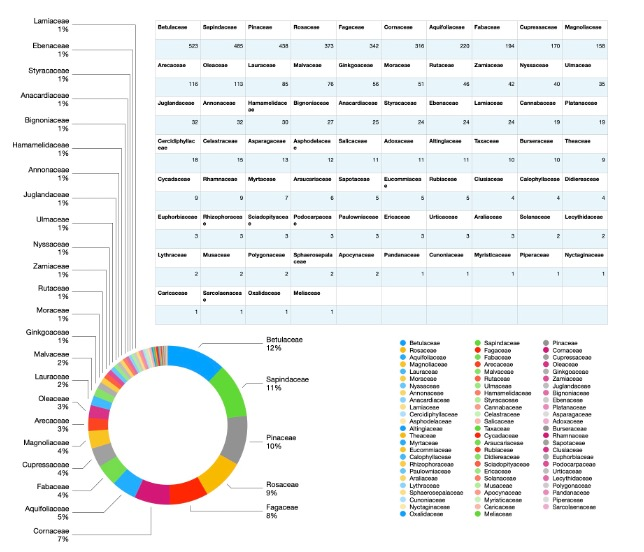

### Training Processing
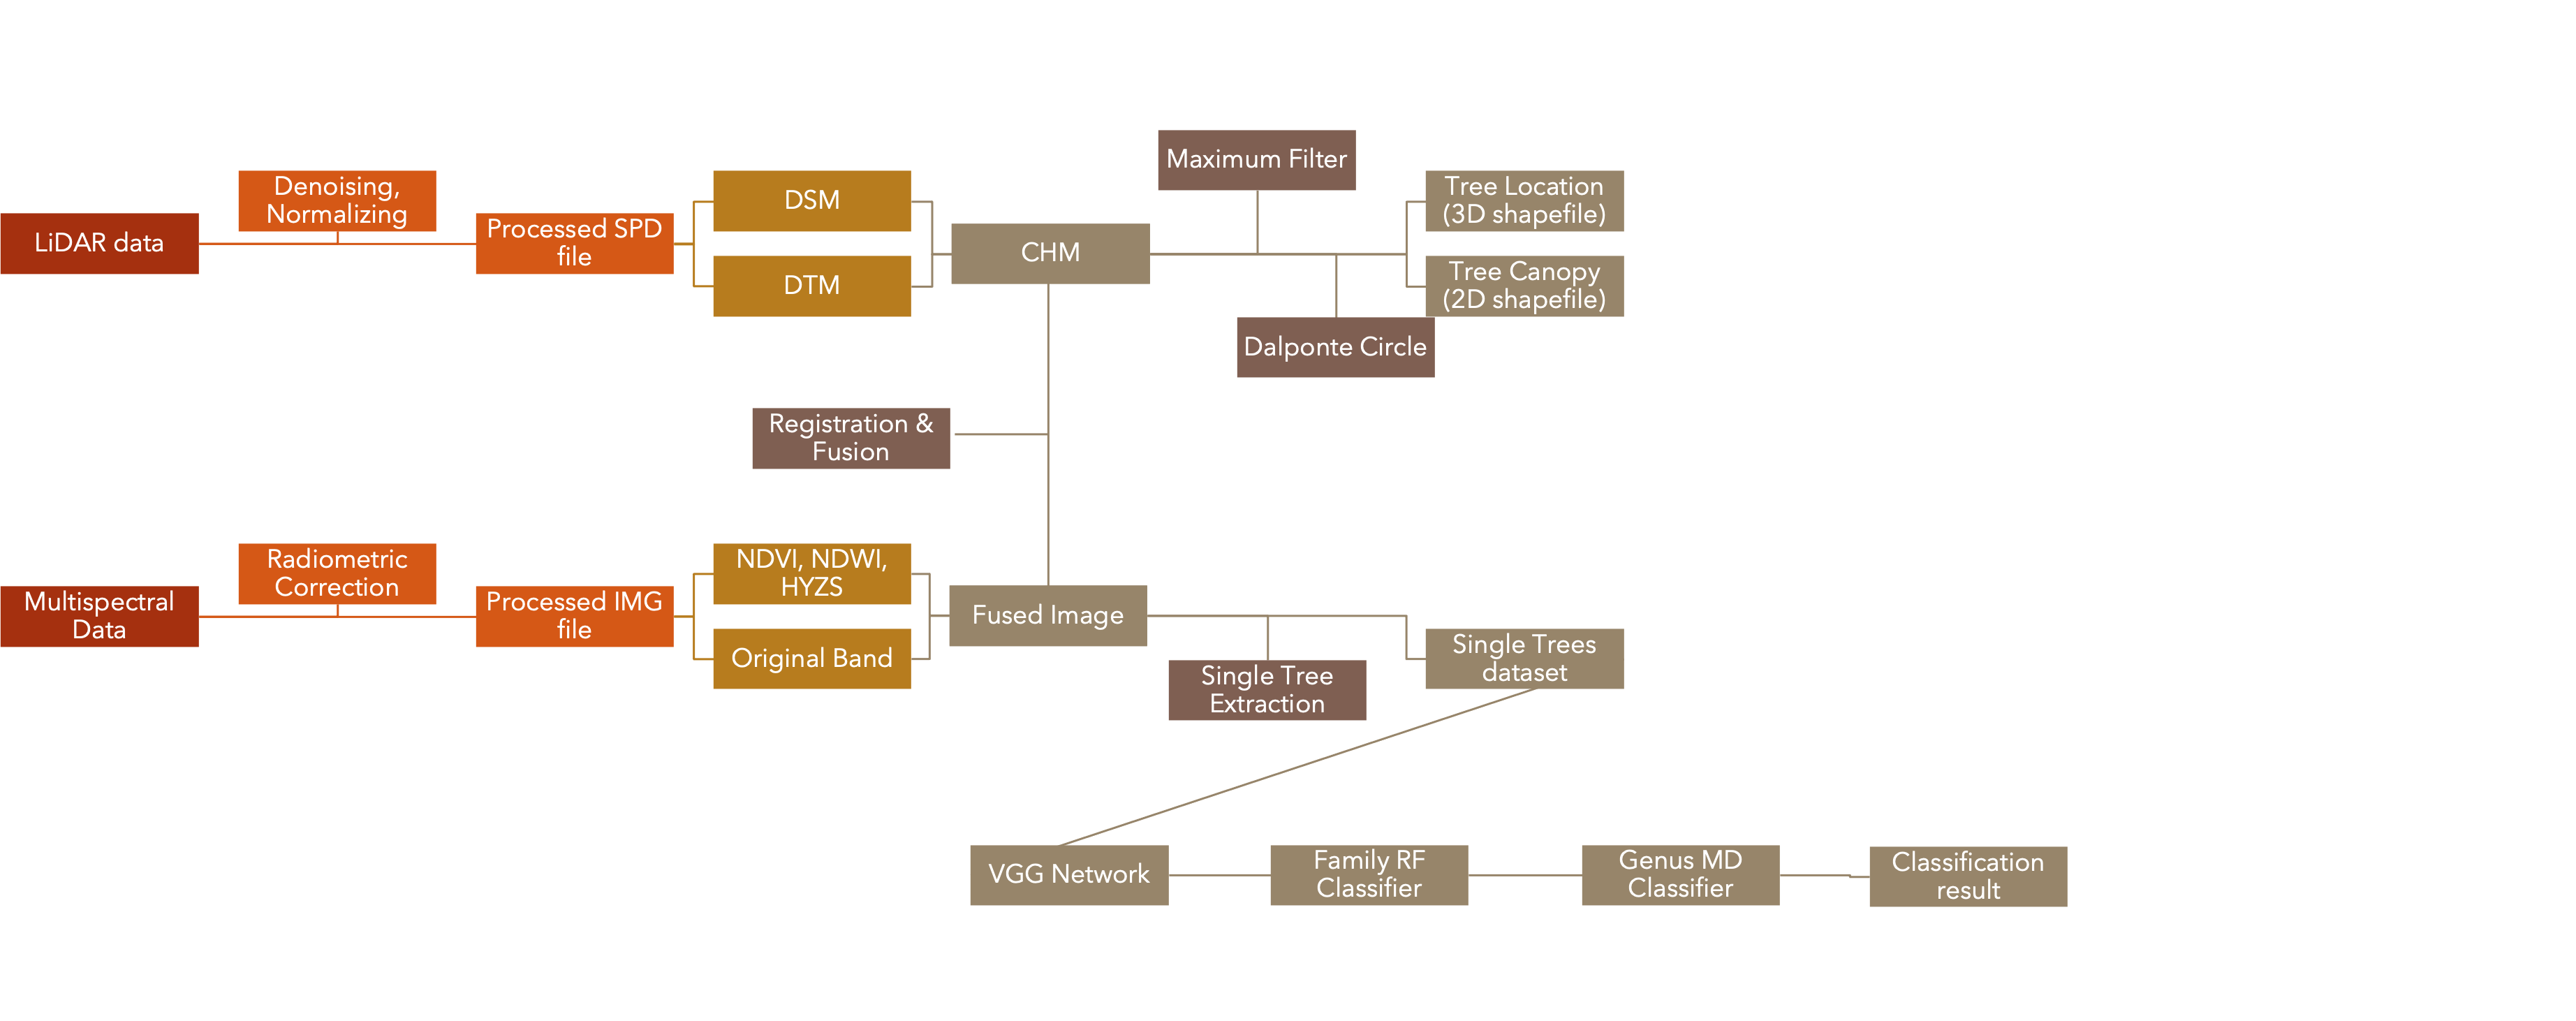

In this challege, we can obtain the processed LiDAR cloud point data in Las or LasZip format. After converting data to SPD file and filtering it, we can use SPDLib to finish some processing work like generating DEM and DSM model.

In [ ]:
! spdtranslate --input las.las --if LAS --of SPD -b 1 \ 
    -x LAST_RETURN --keeptemp --output points.spd --input_proj 102696.wkt

! spdpmfgrd -i points.spd -o points_pmfgrd.spd -b 0.5 -r 50 --initelev 0.1
! spdinterp --dsm --topo -f HFA -b 1 -r 50 --in NATURAL_NEIGHBOR_CGAL -i points_pmfgrd.spd -o dsm.img
! spdinterp --dtm --topo -f HFA -b 1 -r 50 --in NATURAL_NEIGHBOR_CGAL -i points_pmfgrd.spd -o dtm.img

After getting DSM and DTM model in IMG file, we need to translate them as TIFF file into the ESRI:102696 coordinate system which is same as the LiDAR file. Then we can use them to calculate the CHM model after covering unit from feet to meter.

In [ ]:
! gdal_translate -of GTiff dsm.img dsm.tif
! gdal_translate -of GTiff dtm.img dtm.tif
! gdalwarp -s_srs ESRI:102696 -t_srs ESRI:102696 dsm.tif dsm_1.tif
! gdalwarp -s_srs ESRI:102696 -t_srs ESRI:102696 dtm.tif dtm_1.tif
! gdal_calc.py -A dsm_1.tif --outfile=dsm_m.tif --calc="A*0.3048" 
! gdal_calc.py -A dtm_1.tif --outfile=dtm_m.tif --calc="A*0.3048" 
! gdal_calc.py -A dsm_m.tif -B dtm_m.tif --outfile=chm_m.tif --calc="A-B"


Now we get the DSM, DTM, and CHM model.

The tree top mapping and canopy delineation method use local maxima in the canopy height model (CHM) as initial tree locations and identifies the correct tree top positions even in steep terrain by combining a raster-based tree crown delineation approach with information from the digital surface model (DSM) and terrain model (DTM). The first step is identifing tree tops through local maxima in the smoothed CHM. Then there is an additional step to correct for erroneous tree top locations on steep slopes by taking either the high point from the surface model or the centre of mass of the tree crown as new tree top, which would be a 3D shapefile output. After that, we use the crown delineation algorithms from Dalponte and Coomes[7] to detect each tree's canopy and draw a 2D shapefile as canopy output. 

In [ ]:
from datetime import datetime
from code.pycrownmaster.pycrown import PyCrown

In [ ]:
def tree_loc(F_CHM, F_DTM, F_DSM, F_LAS,outpath):
    TSTART = datetime.now()
    
    PC = PyCrown(F_CHM, F_DTM, F_DSM, F_LAS, outpath=outpath)

    # Smooth CHM with 5m median filter
    PC.filter_chm(5, ws_in_pixels=True)

    # Tree Detection with local maximum filter
    PC.tree_detection(PC.chm, ws=1, ws_in_pixels=True, hmin=4.5)

    # Clip trees to bounding box (no trees on image edge)
    PC.clip_trees_to_bbox(inbuf=11)  # inward buffer of 11 metre

    # Crown Delineation
    PC.crown_delineation(algorithm='dalponteCIRC_numba', th_tree=15.,
                         th_seed=0.7, th_crown=0.55, max_crown=32.)

    # Correct tree tops on steep terrain
    PC.correct_tree_tops()

    # Calculate tree height and elevation
    PC.get_tree_height_elevation(loc='top')
    PC.get_tree_height_elevation(loc='top_cor')

    # Screen small trees
    PC.screen_small_trees(hmin=1., loc='top')

    # Convert raster crowns to polygons
    PC.crowns_to_polys_raster()
    PC.crowns_to_polys_smooth(store_las=False)

    # Check that all geometries are valid
    PC.quality_control()

    # Export results
    PC.export_raster(PC.chm, PC.outpath / 'chm.tif', 'CHM')
    PC.export_tree_locations(loc='top')
    PC.export_tree_locations(loc='top_cor')
    PC.export_tree_crowns(crowntype='crown_poly_raster')

    TEND = datetime.now()

    print(f"Number of trees detected: {len(PC.trees)}")
    print(f'Processing time: {TEND-TSTART} [HH:MM:SS]')

In [ ]:
F_CHM = 'data/CHM_m.tif'
F_DTM = 'data/DTM_m.tif'
F_DSM = 'data/DSM_m.tif'
F_LAS = 'data/POINTS.las'
outpath = 'result'

tree_loc(F_CHM, F_DTM, F_DSM, F_LAS,outpath)

This image shows the predicted tree location and canopy mapping.
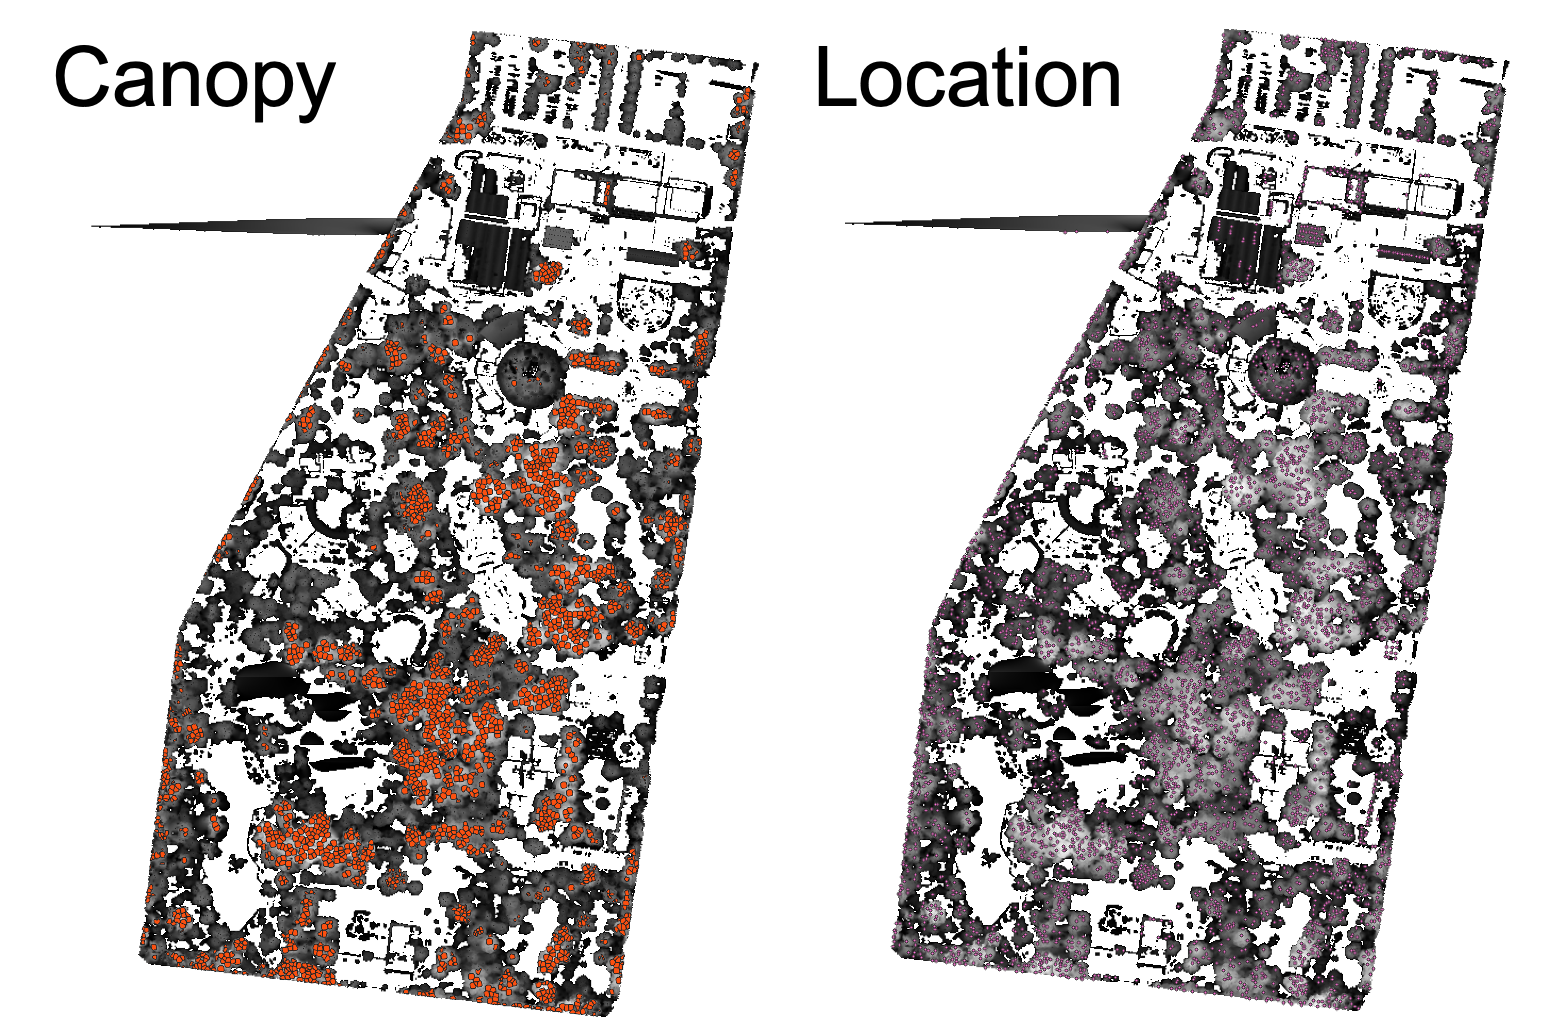

Since the airborne LiDAR and hyperspectral images are from different sensors, mutual registration is required before fusion. The experimentally extracted LiDAR CHM with a resolution of 1 m and the hyperspectral image of the same resolution are unified into the UTM projection WGS-84 coordinate system. Then we use the nearest neighbor resampling method which select 20 typical representative points from the two images to do the perform registration.

In [ ]:
! gdalwarp -s_srs EPSG:26915 -t_srs EPSG:4326 \
        /Users/molanzhang/Documents/plant/data/MOBOT_Processed_Multispectral_Data/mobot_04192021_nrg_re_clip.img \
        /Users/molanzhang/Documents/plant/code/pycrown-master/example/data/rgbd_0.tif 
! gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4326 -of GTiff -tr 1e-06 1e-06 \ 
        -tap -cutline /Users/molanzhang/Documents/plant/data/ww.shp -cl ww -crop_to_cutline \
        /Users/molanzhang/Documents/plant/code/pycrown-master/example/data/rgbd_0.tif \
        /Users/molanzhang/Documents/plant/code/pycrown-master/example/data/rgbd_f.tif
! gdalwarp -s_srs ESRI:102696 -t_srs EPSG:4326 \
        /Users/molanzhang/Documents/plant/code/pycrown-master/example/result/chm.tif \
        /Users/molanzhang/Documents/plant/code/pycrown-master/example/data/chm_0.tif
! gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4326 -of GTiff -tr 1e-06 1e-06 \
        -tap -cutline /Users/molanzhang/Documents/plant/data/ww.shp -cl ww -crop_to_cutline \
        /Users/molanzhang/Documents/plant/code/pycrown-master/example/data/chm_0.tif \
        /Users/molanzhang/Documents/plant/code/pycrown-master/example/data/chm_f.tif


Now we get the registrated GeoTIFF files which named as rgbd_f.tif and chm_f.tif.
Then we need to fused them as an array which can be used to extract single tree based on the canopy fetection map and tree location map. Here we save each tree named by its object ID.  

In [ ]:
from osgeo import gdal,gdal_array
import os
import numpy as np
import shapefile
from PIL import Image,ImageDraw
import csv
import codecs

In [ ]:
def write_tif(img_data,output_name,proj,geoinfo):
    driver = gdal.GetDriverByName('GTiff')
    cols = img_data.shape[2]
    rows = img_data.shape[1]
    out_file = driver.Create(output_name,cols,rows,9,6)
    out_file.SetGeoTransform(geoinfo)
    out_file.SetProjection(proj)
    for i in range(9):
        out_file.GetRasterBand(i+1).WriteArray(img_data[i,:,:])
    del out_file


In [ ]:
def geo2pixel(geoTrans,g_x,g_y):
    x = (g_x - geoTrans[0])/geoTrans[1]
    y = (g_y - geoTrans[3])/geoTrans[5]
    return x,y

In [ ]:
fn = 'Mobot_Trees_20210127_v2.csv'
file_name = 'code/pycrown-master/example/data/rgbd_f.tif'
data = gdal.Open(file_name)
data_Array_nrgbre = gdal_array.LoadFile(file_name)
file_name = 'code/pycrown-master/example/data/chm_f.tif'
data = gdal.Open(file_name)
data_Array_chm = gdal_array.LoadFile(file_name)
proj = data.GetProjection()
geoTrans = data.GetGeoTransform()
width = data.RasterXSize
height = data.RasterYSize

In [ ]:
data_Array = np.zeros((9,height,width))
data_Array[0,:,:] = data_Array_chm
del data_Array_chm
data_Array[1,:,:] = (data_Array_nrgbre[0,:,:]-data_Array_nrgbre[1,:,:])/(data_Array_nrgbre[0,:,:]+data_Array_nrgbre[1,:,:])
data_Array[2,:,:] = (data_Array_nrgbre[0,:,:]-data_Array_nrgbre[4,:,:])/(data_Array_nrgbre[0,:,:]+data_Array_nrgbre[4,:,:])
data_Array[3,:,:] = data_Array_nrgbre[1,:,:] -data_Array_nrgbre[3,:,:]
data_Array[4:,:,:] = data_Array_nrgbre
del data_Array_nrgbre

In [ ]:
i = 0
with codecs.open(fn, 'r','utf-8') as csvfile:
    reader = csv.reader(csvfile)
    # skip the header
    next(reader,'None')
    #loop through each of the rows and assign the attributes to variables
    for row in reader:
        if row[7] == '<Null>' or float(row[7]) == 0.:
            r = 5/0.07
        else:
            r = float(row[7])/2/0.07
        output_file = 'data/08_23/'+str(row[11])
        if not os.path.exists(output_file):
            os.mkdir(output_file)
        output_file = 'data/08_23/'+str(row[11])+'/'+str(row[12])
        if not os.path.exists(output_file):
            os.mkdir(output_file)
        output_file = 'data/08_23/'+str(row[11])+'/'+str(row[12])+'/'+str(row[13])
        if not os.path.exists(output_file):
            os.mkdir(output_file)
        output_name = output_file + '/'+str(i)+'.tif'
        center_x,center_y = geo2pixel(geoTrans, float(row[18]), float(row[17]))
        if center_x*center_y <= 0 or center_x>=width or center_y>=height:
            continue
        start_x = int(max(center_x - r,0))
        start_y = int(max(center_y - r,0))
        end_x = int(min(center_x + r, width))
        end_y = int(min(center_y + r, height))
        clip = data_Array[:,start_y:end_y,start_x:end_x]
        geoinfo_new = list(geoTrans)
        geoinfo_new[0] = geoTrans[0]+geoTrans[1]*start_x;
        geoinfo_new[3] = geoTrans[3]+geoTrans[5]*start_y;
        write_tif(clip,output_name,proj,geoinfo_new)
        i += 1

Now we can use these single tree to train the VGG model and based on the VGG model's output we need to train a SVM classifier, too. Then using the SVM's output to train a MD classifier to get the fianl output.

In [ ]:
import pandas as pd
from osgeo import gdal
from PIL import Image
import matplotlib.image as mpimg
from osgeo import ogr
import subprocess
from tensorflow import keras
import matplotlib.pyplot as plt
import IPython.display as display
import numpy as np
import pathlib
import tensorflow as tf
import torch
import os
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import random

In [ ]:
def get_allfile(path):  
    all_file = []
    for f in os.listdir(path):  
        f_name = os.path.join(path, f)
        all_file.append(f_name)
    return all_file

def listdir(path, list_name):
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        if os.path.isdir(file_path):
            listdir(file_path, list_name)
        else:
            list_name.append(file_path)
    return list_name

In [ ]:
#read the GeoTIFF file
def read_img(dataset_path):
    dataset = gdal.Open(dataset_path)
    im_width = dataset.RasterXSize
    im_height = dataset.RasterYSize
    im_bands = dataset.RasterCount
    im_data = dataset.ReadAsArray(0,0,im_width,im_height)
    del dataset
    temp = np.where(np.isnan(im_data),0,im_data)
    temp = np.transpose(temp,(1,2,0))
    final = np.resize(temp,(224,224,9))
    final = np.transpose(final,(2,0,1))
    return final

In [ ]:
class MyDataset(torch.utils.data.Dataset): #Create my dataset which inherits from torch.utils.data.Dataset
    def __init__(self,txt, level, my_dict, transform=None, target_transform=None):
        super(MyDataset,self).__init__()
        path=txt
        imgs = []
        for line in path:
            words = line.split('/')
            if len(words)< 6 or '.tif' not in line:
                continue
            label = my_dict[words[level+1]]
            imgs.append((line,int(label)))
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        img, label = self.imgs[index]
        image = read_img(img)
        if self.transform is not None:
            image = torch.tensor(image)
        return image,label

    def __len__(self):
        return len(self.imgs)


In [ ]:
class  VGG(nn.Module):
    def __init__(self,num_classes=40):
        super(VGG,self).__init__()
        layers=[]
        in_dim=9
        out_dim=64
        for i in range(13):
            layers+=[nn.Conv2d(in_dim,out_dim,3,1,1),nn.ReLU(inplace=True)]
            in_dim=out_dim
            if i==1 or i==3 or i==6 or i==9 or i==12:
                layers+=[nn.MaxPool2d(2,2)]
                if i!=9:
                    out_dim*=2
        self.features=nn.Sequential(*layers)
        self.classifier=nn.Sequential(
            nn.Linear(512*7*7,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,num_classes),
        )
    def forward(self,x):
        x=self.features(x)
        x=x.view(x.size(0),-1)
        x=self.classifier(x)
        return x

In [ ]:
def train(level=1):
    file_list = listdir('data/single_tree',[])
    family = []
    genus = []
    spices = []
    for f in file_list:
        a = f.split('/')
        if len(a) != 6:
            continue
        family.append(a[2])
        genus.append(a[3])
        spices.append(a[4])
    value = []
    temp = []
    x = list(set(family))
    for i in range(len(x)):
        temp.append([x[i],str(i)])
    family_dict = dict(temp)
    f_class = len(x)
    value = []
    temp = []
    x = list(set(genus))
    for i in range(len(x)):
        temp.append([x[i],str(i)])
    genus_dict = dict(temp)
    g_class = len(x)
    value = []
    temp = []
    x = list(set(spices))
    for i in range(len(x)):
        temp.append([x[i],str(i)])
    spices_dict = dict(temp)
    s_class = len(x)
    
    train_file_list = []
    test_file_list = []
    for i in file_list:
        flag = random.random()
        if flag >= 0.7:
            train_file_list.append(i)
        else:
            test_file_list.append(i)
                
    if level == 1:
        train_data=MyDataset(txt=train_file_list,level = level, my_dict = family_dict, transform='yes')
        test_data=MyDataset(txt=test_file_list,level = level, my_dict = family_dict, transform='yes')
        net = VGG(num_classes=f_class)
    elif level == 2:
        train_data=MyDataset(txt=train_file_list,level = level, my_dict = genus_dict, transform='yes')
        test_data=MyDataset(txt=test_file_list,level = level, my_dict = genus_dict, transform='yes')
        net = VGG(num_classes=g_class)
    else:
        train_data=MyDataset(txt=train_file_list,level = level, my_dict = spices_dict, transform='yes')
        test_data=MyDataset(txt=test_file_list,level = level, my_dict = spices_dict, transform='yes')
        net = VGG(num_classes=s_class)

    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=16, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=16)

    net = net.float()
    criterion =torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(),lr = 0.005 )

    acc_test = []
    acc_train = []
    loss_train = []
    loss_test = []
    hign_acc = 0.
    for epoch in range(50):
        net.train()
        for i, data in enumerate(train_loader,0):
            img, label = data
            optimizer.zero_grad()
            output = net(img)
            prediction = torch.max(F.softmax(output), 1)[1]
            pred = prediction.data.numpy().squeeze()
            x = label.data.numpy().squeeze()
            acc_now = pred-x
            temp = np.sum(acc_now == 0)
            acc_train.append(temp/len(label))
            loss_contrastive = criterion(output,label)
            loss_contrastive.backward()
            optimizer.step()
            loss_train.append(loss_contrastive.item())
            print("train times: {}\nEpoch number {}\n Current loss {}\n Current accuracy {}\n" \ 
                  .format(i,epoch,loss_contrastive.item(),temp/len(label)))
            if temp/len(label) > hign_acc:
                torch.save(net,'model_'+str(level)+'.pth')
                hign_acc = temp/len(label)
        else:
            net.eval()
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                for i, data in enumerate(test_loader,0):
                   img, label= data
                   out = net(img)
                   prediction = torch.max(F.softmax(out), 1)[1]
                   x = label.data.numpy().squeeze()
                   pred = prediction.data.numpy().squeeze()
                   acc_now = pred-x
                   temp = np.sum(acc_now == 0)
                   acc_test.append(temp/len(label))
                   loss_contrastive = criterion(out,label)
                   loss_test.append(loss_contrastive.item())
                    print("train times: {}\nEpoch number {}\n Current loss {}\n Current accuracy {}\n" \ 
                          .format(i,epoch,loss_contrastive.item(),temp/len(label)))
    return acc_train,loss_train, acc_test, loss_test


### Training Results

#### Location and canopy detection 

Based on this picture, we can see that the purple point is our detected location and orange points is the ground truth. The pink polygon is the canopy detection map. Some small tree's canopy have not be detected so that we need to combine location and canopy file together to make sure every detected tree will be extract. So here we will check if one point is not in a polygon, we will assume this tree's canopy width is 10m and extract it.
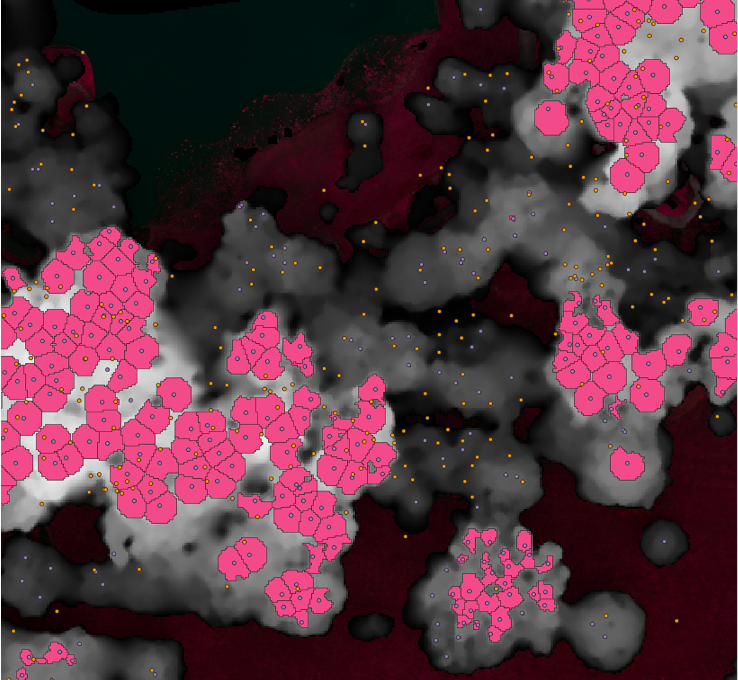

Based on training dataset, our team randomly split it as training dataset (80%) and validation dataset (20%) which is used to verify if our model works well. This table shows the validation result based on our step by step models. We believe that our model can work well on the similarity dataset.
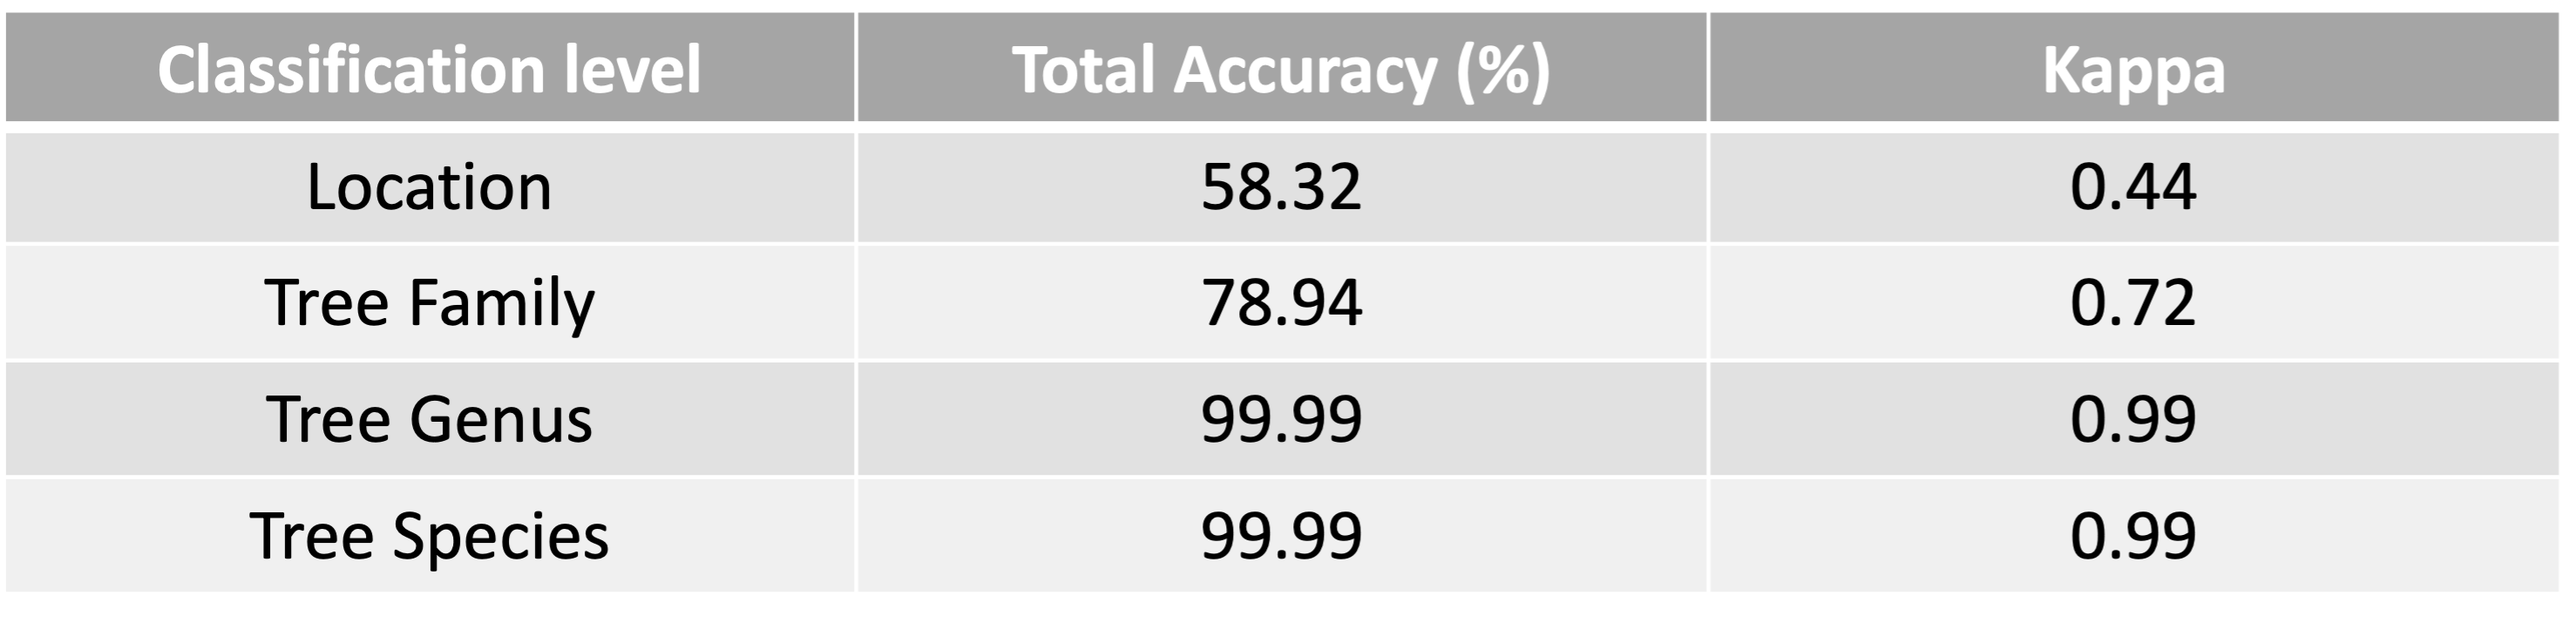

### Testing Processing

Just like what we did in the training part, firstly we need to convert all Las file as SPD file. 

In [ ]:
def comman(data,spd,spd_pmfgrd,dsm,dtm,chm):
    dsm_tif = dsm.replace('.img','.tif')
    dsm_1_tif = dsm.replace('.img','_1.tif')
    dsm_m = dsm.replace('.img','_m.tif')
    dtm_tif = dtm.replace('.img','.tif')
    dtm_1_tif = dtm.replace('.img','_1.tif')
    dtm_m = dtm.replace('.img','_m.tif')
    ! spdtranslate --input {data} --if LAS --of SPD -b 1 \ 
    -x LAST_RETURN --keeptemp --output {spd} --input_proj 102696.wkt

    ! spdpmfgrd -i {spd} -o {spd_pmfgrd} -b 0.5 -r 50 --initelev 0.1
    ! spdinterp --dsm --topo -f HFA -b 1 -r 50 --in NATURAL_NEIGHBOR_CGAL -i {spd_pmfgrd} -o {dsm}
    ! spdinterp --dtm --topo -f HFA -b 1 -r 50 --in NATURAL_NEIGHBOR_CGAL -i {spd_pmfgrd} -o {dtm}
    ! gdal_translate -of GTiff {dsm} {dsm_tif}
    ! gdal_translate -of GTiff {dtm} {dtm_tif}
    ! gdalwarp -s_srs ESRI:102696 -t_srs ESRI:102696 {dsm_tif} {dsm_1_tif}
    ! gdalwarp -s_srs ESRI:102696 -t_srs ESRI:102696 {dtm_tif} {dtm_1_tif}
    ! gdal_calc.py -A {dsm_1_tif} --outfile={dsm_m_tif} --calc="A*0.3048" 
    ! gdal_calc.py -A {dtm_1_tif} --outfile={dtm_m_tif} --calc="A*0.3048" 
    ! gdal_calc.py -A {dsm_m_tif} -B {dtm_m_tif} --outfile={chm} --calc="A-B"


In [ ]:
def merge(outpath,folder):
    chm = outpath+'/chm.tif'
    chm0 = '/'.join(folder)+'/chm_0.tif)
    chm_f = '/'.join(folder)+'/chm_f.tif'
    temp = listdir('/'.join(folder),[])
    for i in temp:
        if '.img' in i and '_iwir_' not in i:
            rgbd = i
            break
    rgbd0 = '/'.join(folder)+'/rgbd_0.tif'
    rgbd_f = '/'.join(folder)+'/rgbd_f.tif'
    
    ! gdalwarp -s_srs EPSG:26915 -t_srs EPSG:4326 {rgbd} {rgbd_0}
    ! gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4326 -of GTiff -tr 1e-06 1e-06 \ 
            -tap -cutline /Users/molanzhang/Documents/plant/data/ww.shp -cl ww -crop_to_cutline \
            {rgbd0} {rgbd_f}
    ! gdalwarp -s_srs ESRI:102696 -t_srs EPSG:4326 {chm} {chm0}
    ! gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4326 -of GTiff -tr 1e-06 1e-06 \
            -tap -cutline /Users/molanzhang/Documents/plant/data/ww.shp -cl ww -crop_to_cutline \
            {chm0} {chm_f}


In [ ]:
def extract_single_tree_6(folder):
    fn = folder+'/result/tree_crown_poly_raster.shp'
    file_name = folder+'/rgbd_f.tif'
    data = gdal.Open(file_name)
    data_Array_nrgbre = gdal_array.LoadFile(file_name)
    file_name = folder+'/chm_f.tif'
    data = gdal.Open(file_name)
    data_Array_chm = gdal_array.LoadFile(file_name)
    proj = data.GetProjection()
    geoTrans = data.GetGeoTransform()
    width = data.RasterXSize
    height = data.RasterYSize
    data_Array = np.zeros((9,height,width))

    data_Array[0,:,:] = data_Array_chm
    del data_Array_chm
    data_Array[1,:,:] = (data_Array_nrgbre[0,:,:]-data_Array_nrgbre[1,:,:])/(data_Array_nrgbre[0,:,:]+data_Array_nrgbre[1,:,:])
    data_Array[2,:,:] = (data_Array_nrgbre[0,:,:]-data_Array_nrgbre[4,:,:])/(data_Array_nrgbre[0,:,:]+data_Array_nrgbre[4,:,:])
    data_Array[3,:,:] = data_Array[3,:,:] = data_Array_nrgbre[1,:,:] -data_Array_nrgbre[3,:,:]
    data_Array[4:,:,:] = data_Array_nrgbre
    del data_Array_nrgbre

    i = 0
    with codecs.open(fn, 'r','utf-8') as csvfile:
        shp = shapefile.Reader('label.shp')
        reader = shp.shapes()
        for poly in reader:
            minX,minY,maxX,maxY = poly.bbox
            output_file = folder+'/single_tree/'
            output_name = output_file + str(i)+'.tif'
            start_pos_x,start_pos_y = geo2pixel(geoTrans, minX,maxY)
            end_pos_x,end_pos_y = geo2pixel(geoTrans, maxX,minY)
            clip = data_Array[:,start_pos_y:end_pos_y,start_pos_x:end_pos_x]
            geoinfo_new = list(geoTrans)
            geoinfo_new[0] = minX;
            geoinfo_new[3] = maxY;
            write_tif(9, clip,output_name,proj,geoinfo_new)
            i += 1
    

In [ ]:
def extract_single_tree_4(folder):
    fn = folder+'/result/tree_crown_poly_raster.shp'
    file_name = folder+'/rgbd_f.tif'
    data = gdal.Open(file_name)
    data_Array_nrgbre = gdal_array.LoadFile(file_name)
    file_name = folder+'/chm_f.tif'
    data = gdal.Open(file_name)
    data_Array_chm = gdal_array.LoadFile(file_name)
    proj = data.GetProjection()
    geoTrans = data.GetGeoTransform()
    width = data.RasterXSize
    height = data.RasterYSize
    data_Array = np.zeros((7,height,width))

    data_Array[0,:,:] = data_Array_chm
    del data_Array_chm
    data_Array[1,:,:] = (data_Array_nrgbre[0,:,:]-data_Array_nrgbre[1,:,:])/(data_Array_nrgbre[0,:,:]+data_Array_nrgbre[1,:,:])
    data_Array[2,:,:] = (data_Array_nrgbre[0,:,:]-data_Array_nrgbre[3,:,:])/(data_Array_nrgbre[0,:,:]+data_Array_nrgbre[3,:,:])
    data_Array[3:,:,:] = data_Array_nrgbre
    del data_Array_nrgbre

    i = 0
    with codecs.open(fn, 'r','utf-8') as csvfile:
        shp = shapefile.Reader('label.shp')
        reader = shp.shapes()
        for poly in reader:
            minX,minY,maxX,maxY = poly.bbox
            output_file = folder+'/single_tree/'
            output_name = output_file + str(i)+'.tif'
            start_pos_x,start_pos_y = geo2pixel(geoTrans, minX,maxY)
            end_pos_x,end_pos_y = geo2pixel(geoTrans, maxX,minY)
            clip = data_Array[:,start_pos_y:end_pos_y,start_pos_x:end_pos_x]
            geoinfo_new = list(geoTrans)
            geoinfo_new[0] = minX;
            geoinfo_new[3] = maxY;
            write_tif(7, clip,output_name,proj,geoinfo_new)
            i += 1

In [ ]:
def pred(x,level,flag):
    filename = 'model/svm'+flag+level+'.sav'
    net = joblib.load(filename)
    filename = 'model/pca'+flag+level+'.sav'
    pcamodel = joblib.load(filename)
    data = pcamodel.transform(x)
    predicted=net.predict(data)
    return predicted

In [ ]:
list_file = listdir('testdata',[])
for data in list_file:
    if '.las' not in data:
        continue
    spd = data.replace('.las','.spd')
    spd_pmfgrd = data.replace('.las','_pmfgrd.spd')
    dsm = data.replace('.las','_dsm.img')
    dtm = data.replace('.las','_dtm.img')
    chm = data.replace('.las','_chm_m.tif')
    comman(data,spd,spd_pmfgrd,dsm,dtm,chm)
    dtm_m = dtm.replace('.img','_m.tif')
    dsm_m = dsm.replace('.img','_m.tif')
    outpath = data.replace('.las','/result')
    os.mkdir(outpath)
    tree_loc(chm, dtm_m, dsm_m, data,outpath)
    folder = data.split('/')
    folder = folder[:-1]
    
    merge(outpath, folder)
    
    if '08232021' in data or '11012021' in data:
        extract_single_tree_6(folder)
    else:
        extract_single_tree_4(folder)
        

In [ ]:
results = open('results.csv','w',newline='')
csv_writer = csv.writer(f)
csv_writer.writerow(['Family','Genus','Species','Latitude','Longitude'])
with open('dict/family_dict.pkl','rb') as f:
    family_dict = pickle.load(f)
with open('dict/genus_dict.pkl','rb') as f:
    genus_dict = pickle.load(f)
with open('dict/spices_dict.pkl','rb') as f:
    spices_dict = pickle.load(f)

file_list = listdir('testdata',[])
for line in file_list:
    if '/single_tree/' not in line:
        continue
    if '08232021' in data or '11012021' in data:
        flag = 6
    else:
        flag = 4
    x,lat,lon =load_data(line)
    pred_f = pred(x,'f',flag)
    f_name = family_dict[str(pred_f)]
    pred_g = pred(x,f_name,flag)
    g_name = genus_dict[str(pred_f)]
    pred_s = pred(x,g_name,flag)
    s_name = spices_dict[str(pred_f)]
    csv_writer.writerow([f_name,g_name,s_name,str(lat),str(lon)])


In [ ]:
df = pd.read_csv('results_temp.csv',index_col=0)
df['x_y'] = df.apply(lambda x: str(x['Latitude']) + '__' + str(x['Longitude']))
count = df['x_y'].value_counts()
output = pd.DataFrame([],columns=['Family','Genus','Species','Latitude','Longitude'])
for i in range(len(count)):
    loc = count.index[i]
    df1 = df[df['x_y']==loc]
    f = list(df1['Family'])
    g = list(df1['Genus'])
    s = list(df1['Species'])
    ss = Counter(s)
    ss = ss.most_common()
    if len(ss>1) and (ss[0][1] == ss[1][1]):
        gg = Counter(g)
        gg = gg.most_common()
        if len(gg>1) and (gg[0][1] == gg[1][1]):
            ff = Counter(f)
            ff = ff.most_common()
            df2 = df1[df1['Family']==ff[0][0]]
            label = df2.iloc[0,:-1]
        else:
            df2 = df1[df1['Genus']==gg[0][0]]
            label = df2.iloc[0,:-1]
    else:
        df2 = df1[df1['Species']==ss[0][0]]
        label = df2.iloc[0,:-1]
    output.append(label,ignore_index=True)
output.to_csv('results.csv')

### Testing Results

In [1]:
import folium 
import codecs
import csv
from pyproj import CRS
from pyproj import Transformer

loc = 'Plant Recognition University Challenge Predicted Map'
title_html = '''<h3 align="center" style="font-size:16px"><b>{}</b></h3>'''.format(loc)   

m = folium.Map(
    location=[38.631391, -91.862897],
    zoom_start=15,
)

tooltip = 'Click to see predicted tree species.'
from_crs = CRS.from_wkt('PROJCS["WGS_1984_UTM_Zone_15N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["Meter",1]]')
to_crs = CRS.from_wkt('GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]]')

transformer = Transformer.from_crs(from_crs,to_crs,always_xy=True)

with codecs.open('results.csv', 'r','utf-8') as csvfile:
    reader = csv.reader(csvfile)
    # skip the header
    next(reader,'None')
    #loop through each of the rows and assign the attributes to variables
    for row in reader:
        f = row[2]
        g = row[3]
        s = row[6]
        lat=row[4]
        lon=row[5]
        x1,y1 = transformer.transform(lat,lon)
        test = folium.Html('<b>Family:{}</b></br> <b>Genus:{}</b></br> <b>Species:{}</b></br>'.format(f,g,s), script=True)
        popup = folium.Popup(test, max_width=2650)
        folium.Marker([y1,x1], popup=popup, tooltip=tooltip).add_to(m)
m.get_root().html.add_child(folium.Element(title_html))
m    


In [2]:
m.save('results_map.html')

## Risks 

A multispectral camera is practically more low-cost than the use of a multispectral camera. However, to this date, the multispectral camera (that is developed as a small UAV payload sensor) is exclusively developed for agriculture applications (e.g., the Sequoia+ camera) with several pre-determined spectral bands (that are often tuned for crop health, e.g., water stress, and soil mapping). For plant species identification, more granular signatures at various spectral bands may be crucial to the success for indentifying plant types, specifically down to plant specices. With the ‘good’ accuracy achieved in our training and testing phase, however, we belive that the generalizaion performance may encouter challenges if new datasets captured at different days/weather conditions may are used (namely, our developed models overlly ‘fit’ the limited data we have or more fundamental spectral features of specific plant specicies are not in the training data we posses). 

In this case, a continuous band of spectral data, ranging from visible to near-infrared frequiencies can provide a much high overall accuracy. We believe that as hyspectral imaging sensors become cheaper, this should be of interest in the future. 

## Conclusion

Through experiments on multispectral data and LiDAR data from the Challenge Event, our team can find that our proposed method of fusion of multispectral data and LiDAR data and fusion of deep learning and point cloud data processing can improve the classification accuracy, and when the training samples are limited, the classification accuracy of the method is better than some traditional fusion classification methods of multispectral data and multi-source remote sensing data and fusion classification methods based on deep learning.

However, due to the name format changed for the test data, like the season information lost, our model may can not have a best performance. We believe that if we can get the full information about the senser and photo taken date, our model can perform better. Anyway, facing the data changed, our model shows great robust and still paly well, which means that it is flexible enough to face some complex envirment like unknown senser or totally new photo taken place, which also an important contribution from our model.